# GitHub link with dataset
https://github.com/RinoFrawii/Lab3-Social-Media

# Load and Inspect Dataset

In [1]:
import pandas as pd

# Load CSV
df = pd.read_csv('preprocessed_kindle_review .csv')

# Preview
df.head()


,Unnamed: 0,rating,reviewText,summary
0,0,5,This book was the very first bookmobile book I...,50 + years ago...
1,1,1,"When I read the description for this book, I c...",Boring! Boring! Boring!
2,2,5,I just had to edit this review. This book is a...,Wiggleliscious/new toy ready/!!
3,3,5,I don't normally buy 'mystery' novels because ...,Very good read.
4,4,5,"This isn't the kind of book I normally read, a...",Great Story!


#  Aspect-Based Sentiment Analysis (ABSA) Using Dependency Parsing

In [ ]:
import pandas as pd
import spacy
from textblob import TextBlob
from spacy import displacy

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

# extract and display dependency info
def analyze_sentence(sentence):
    doc = nlp(sentence)
    
    print("{:<15} | {:<8} | {:<15} | {:<20}".format('Token', 'Relation', 'Head', 'Children'))
    print("-" * 70)
    
    for token in doc:
        print("{:<15} | {:<8} | {:<15} | {:<20}"
              .format(str(token.text), str(token.dep_), str(token.head.text), str([child.text for child in token.children])))

    # Dependency visual
    displacy.render(doc, style='dep', jupyter=True, options={'distance': 120})

    return doc

# extract aspects and opinions (noun + adjective)
def extract_aspects(doc):
    aspects = []

    for token in doc:
        if token.dep_ == 'amod' and token.head.pos_ == 'NOUN':
            aspect = token.head.text
            opinion = token.text
            sentiment_score = TextBlob(opinion).sentiment.polarity
            sentiment = "positive" if sentiment_score > 0 else "negative" if sentiment_score < 0 else "neutral"
            aspects.append({
                "aspect": aspect,
                "opinion_word": opinion,
                "sentiment": sentiment,
                "score": sentiment_score
            })

    return aspects

# Example review sentence from the dataset
sentence = "The Kindle's screen is amazing but the battery life is disappointing."

# Analyze sentence
doc = analyze_sentence(sentence)

# Extract aspect-opinion pairs
extracted = extract_aspects(doc)

# Display extracted results
print("\nExtracted Aspects & Sentiments:")
for item in extracted:
    print(f"- Aspect: {item['aspect']}, Opinion: {item['opinion_word']}, Sentiment: {item['sentiment']} (Score: {item['score']:.2f})")



Token           | Relation | Head            | Children            
----------------------------------------------------------------------
The             | det      | Kindle          | []                  
Kindle          | poss     | screen          | ['The', "'s"]       
's              | case     | Kindle          | []                  
screen          | nsubj    | is              | ['Kindle']          
is              | ROOT     | is              | ['screen', 'amazing', 'but', 'is']
amazing         | acomp    | is              | []                  
but             | cc       | is              | []                  
the             | det      | life            | []                  
battery         | compound | life            | []                  
life            | nsubj    | is              | ['the', 'battery']  
is              | conj     | is              | ['life', 'disappointing', '.']
disappointing   | acomp    | is              | []                  
.               | pun


Extracted Aspects & Sentiments:


 # Unsupervised ML

# LDA Topic Modeling

In [3]:
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import pandas as pd

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Preprocessing
stop_words = set(stopwords.words('english'))
texts = [
    [word for word in word_tokenize(str(doc).lower()) if word.isalpha() and word not in stop_words]
    for doc in df['reviewText'].dropna().sample(1000, random_state=42)
]

# Create dictionary and corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train LDA Model
lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

# Extract topic data into a table
topic_data = []
for idx, topic in lda_model.print_topics(num_words=10):
    topic_clean = topic.replace('"', '').replace('+', '')
    keywords = [kw.split('*')[1].strip() for kw in topic_clean.split() if '*' in kw]
    topic_data.append({"Topic Number": idx, "Top Keywords": ", ".join(keywords)})

# Create DataFrame
topic_df = pd.DataFrame(topic_data)

# Display as table
from IPython.display import display
display(topic_df)



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mudhr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mudhr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Topic Number,Top Keywords
0,0,"story, book, read, one, would, love, good, lik..."
1,1,"book, read, story, author, like, one, characte..."
2,2,"book, story, read, would, like, sex, author, c..."
3,3,"story, book, like, one, love, series, characte..."
4,4,"book, read, one, story, like, reading, charact..."


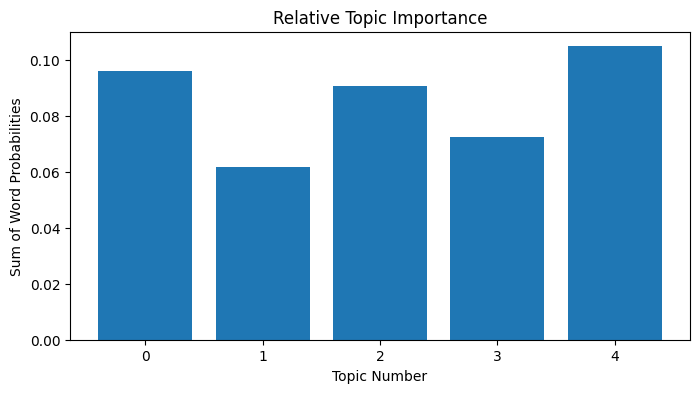

In [ ]:
import matplotlib.pyplot as plt

# Get topic importance
topic_weights = [sum([w for _, w in lda_model.get_topic_terms(i)]) for i in range(lda_model.num_topics)]

# Plot
plt.figure(figsize=(8, 4))
plt.bar(range(len(topic_weights)), topic_weights)
plt.title("Relative Topic Importance")
plt.xlabel("Topic Number")
plt.ylabel("Sum of Word Probabilities")
plt.show()


# Aspect Embedding Generation


In [ ]:
import pandas as pd
import spacy
import os

# Load Spacy English model
nlp = spacy.load("en_core_web_sm")

# Function to extract aspects (noun with adjective modifier)
def extract_aspects(doc):
    aspects = []
    for token in doc:
        if token.dep_ == 'amod' and token.head.pos_ == 'NOUN':
            aspects.append(token.head.text)
    return list(set(aspects))

# Build sentence-aspect pairs
absa_data = []

for text in df['reviewText']:
    doc = nlp(str(text))
    aspects = extract_aspects(doc)
    for aspect in aspects:
        absa_data.append({
            "sentence": text,
            "aspect": aspect
        })

# Convert to DataFrame
absa_df = pd.DataFrame(absa_data)

# Check output
print(f"Generated {len(absa_df)} sentence-aspect pairs.")
absa_df.head()


Generated 54718 sentence-aspect pairs.


,sentence,aspect
0,This book was the very first bookmobile book I...,book
1,This book was the very first bookmobile book I...,grade
2,"When I read the description for this book, I c...",theme
3,"When I read the description for this book, I c...",read
4,"When I read the description for this book, I c...",characters


# Supervised ML – Sentiment Classification

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load CSV
df = pd.read_csv('preprocessed_kindle_review .csv')

# Create labels
def label_sentiment(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

df = df.dropna(subset=['reviewText', 'rating'])
df['label'] = df['rating'].apply(label_sentiment)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['reviewText'], df['label'], test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train Classifier
model = RandomForestClassifier()
model.fit(X_train_vec, y_train)

# Evaluate
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    negative       0.70      0.72      0.71       799
     neutral       1.00      0.01      0.01       412
    positive       0.69      0.92      0.79      1189

    accuracy                           0.70      2400
   macro avg       0.80      0.55      0.51      2400
weighted avg       0.75      0.70      0.63      2400



# Class Distribution

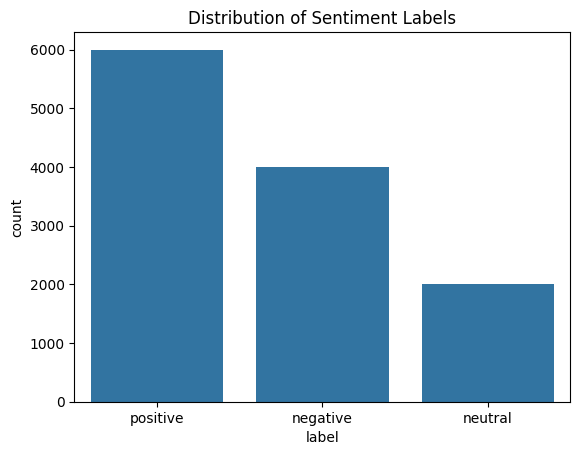

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=df)
plt.title("Distribution of Sentiment Labels")
plt.show()
